In [1]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import DOWNSTREAM_RESULTS_DIR
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import MOOD_BASELINES
from mood.utils import get_outlier_bounds
from mood.metrics import Metric

In [2]:
SUBDIR = "20221213"

In [3]:
in_dir = dm.fs.join(DOWNSTREAM_RESULTS_DIR, "dataframes", "compare_performance", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [4]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, MOOD_BASELINES, MOOD_REPRESENTATIONS))
assert len(list(all_triplets)) == len(paths), find_missing(paths, all_triplets)

In [5]:
df_original = pd.concat([pd.read_csv(p) for p in tqdm.tqdm(paths)], ignore_index=True)
# The "P450" is actually not informative, but these results were generated before abbreviating the name
df_original["dataset"] = df_original["dataset"].apply(lambda x: "CYP2C9" if x == "CYPP4502C9" else x)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:53<00:00,  3.68it/s]


In [6]:
df_original.groupby(["type", "metric"])[["iid_score", "ood_score"]].describe()

iid_score                                            \
                            count       mean        std       min       25%   
type        metric                                                            
calibration Brier score     108.0   0.350556   0.112953  0.075731  0.284675   
            Spearman         90.0   0.232426   0.179175 -0.215391  0.103626   
performance AUROC           108.0   0.750894   0.072980  0.495633  0.716098   
            MAE              90.0  16.428680  26.788809  0.307306  0.621488   

                                                         ood_score             \
                              50%        75%         max     count       mean   
type        metric                                                              
calibration Brier score  0.362059   0.403490    0.755181     108.0   0.361225   
            Spearman     0.210019   0.356324    0.673074      90.0   0.182724   
performance AUROC        0.754349   0.803704    0.886833     108.0   0.717557   
            MAE          9.997371  23.092962  231.291733      90.0  17.015912   

                                                                              \
                               std       min       25%        50%        75%   
type        metric                                                             
calibration Brier score   0.121320  0.078527  0.296191   0.371217   0.422019   
            Spearman      0.187156 -0.187380  0.032394   0.161012   0.293489   
performance AUROC         0.067393  0.497653  0.692587   0.726328   0.759385   
            MAE          21.361736  0.311015  0.754549  11.374368  28.460526   

                                     
                                max  
type        metric                   
calibration Brier score    0.763074  
            Spearman       0.676177  
performance AUROC          0.875109  
            MAE          159.147614

In [7]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# Upscale the Spearman correlation to go from [-1, 1] to [0, 1]
df.loc[df["metric"] == "Spearman", "iid_score"] = (df["iid_score"] + 1) / 2
df.loc[df["metric"] == "Spearman", "ood_score"] = (df["ood_score"] + 1) / 2

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# Since we observed above that there is no negative scores
# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

# Invert the gap of metrics that need to be minimized, so that a high gap is always better
df["metric_direction"] = df["metric"].apply(lambda x: Metric.by_name(x).mode)
df.loc[df["gap"] == "min", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "min", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,gap,relative_gap,metric_direction
0,BBB,GP,ChemBERTa,0.777683,0.703392,AUROC,performance,-0.074291,-9.552875,max
1,BBB,GP,ChemBERTa,0.532443,0.576794,Brier score,calibration,0.044352,-8.329877,min
2,BBB,GP,Desc2D,0.782846,0.785730,AUROC,performance,0.002884,0.368380,max
3,BBB,GP,Desc2D,0.441239,0.440911,Brier score,calibration,-0.000328,0.074418,min
4,BBB,GP,ECFP6,0.782923,0.610287,AUROC,performance,-0.172636,-22.050209,max


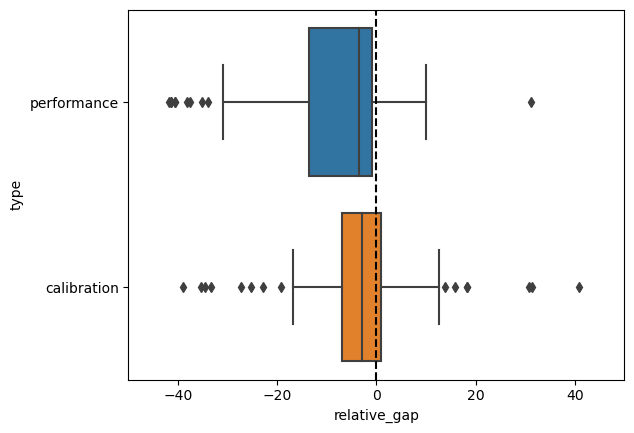

In [8]:
ax = sns.boxplot(data=df, x="relative_gap", y="type")
ax.set_xlim([-50, 50])
ax.plot([0, 0], ax.get_ylim(), "k--")

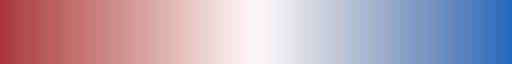

In [9]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
cmap

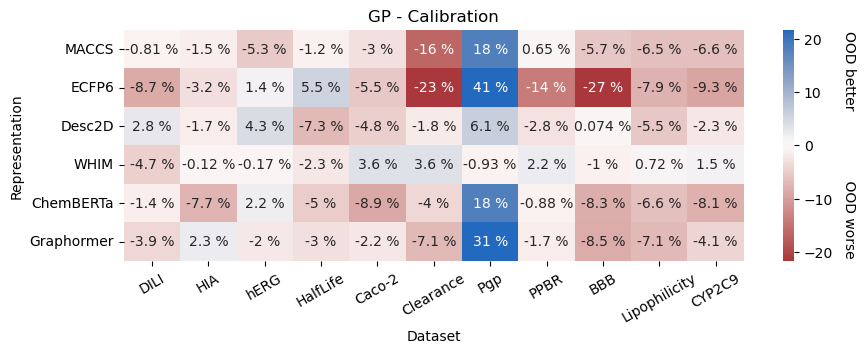

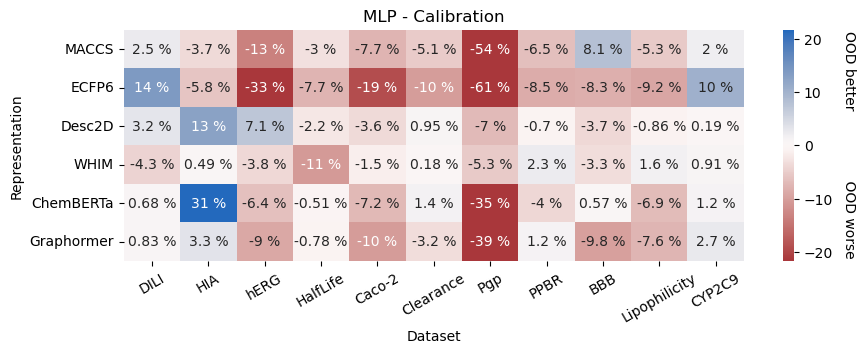

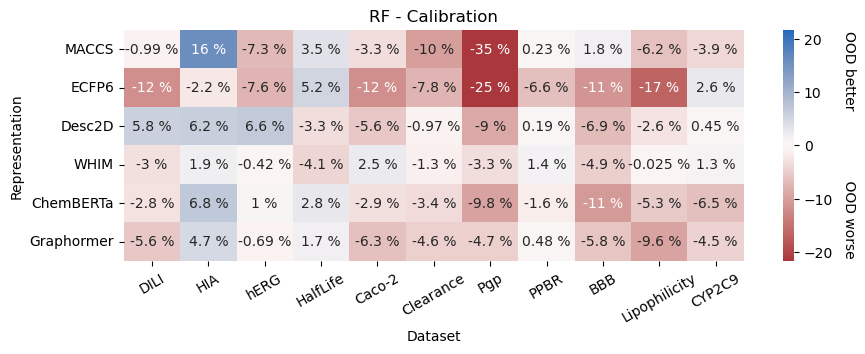

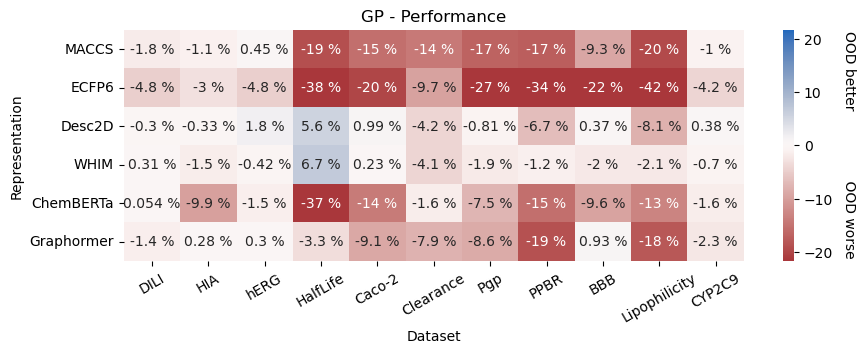

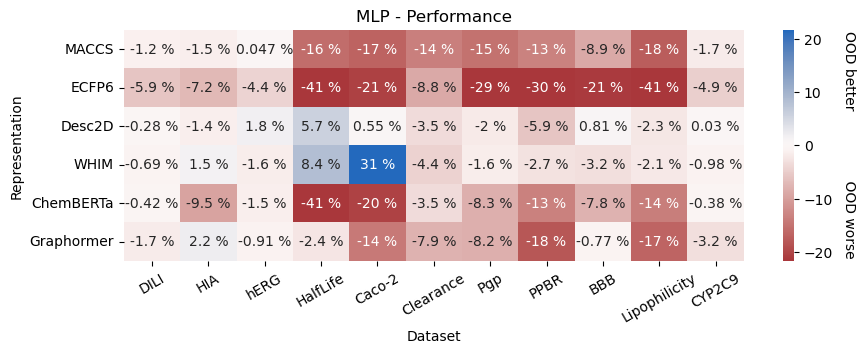

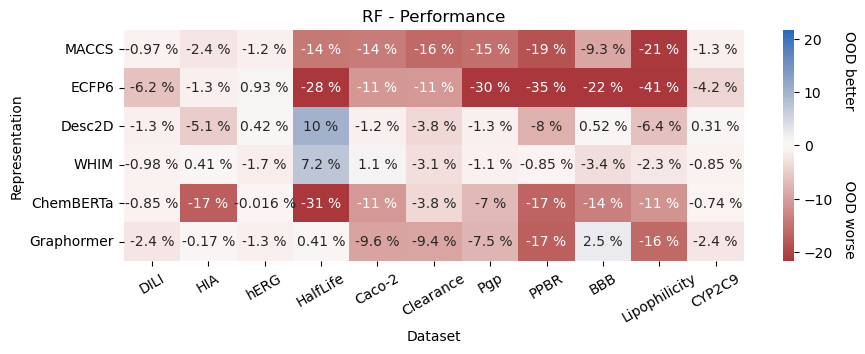

In [10]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        pivot = pivot.reindex(MOOD_REPRESENTATIONS)
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(f"{name} - {metric_type.capitalize()}")
        ax.text(
            0.85, 
            0.5, 
            f"{'OOD better':25} OOD worse", 
            rotation=-90, 
            ha="center", 
            va="center", 
            transform=fig.transFigure
        )

The End.